# Rockall Trough transport

In [1]:
%load_ext autoreload
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
%matplotlib inline
from matplotlib import pyplot as plt
import src.features.RT_functions as rtf
import src.features.RT_data as rtd

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v0'
script_name = f"0.1_Rockall_Trough_moorings_plot_data_{date_str_start[:-2]}_{date_str_end[:-2]}"

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/data/{script_name}/"
Path(data_out_path).mkdir(parents=True, exist_ok=True)

fn_base = "Rockall_Trough_transport_time_series"
file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_{fn_version}.nc"

In [5]:
# intput data
global_data_path = Path("C:/Users/sa07kb/OneDrive - SAMS/data/")
raw_data_path = Path('../data/raw')

# file directories
GEBCO_data_path = (global_data_path/ 'data_GEBCO')
GLORYS_data_path = (global_data_path/ 'data_GLORYS')
RT_mooring_data_path = (global_data_path/ 'data_RT_mooring')
ERA5_data_path = (global_data_path/ 'data_ERA5/Rockall_Trough')

# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_v0.nc'
RT_mooring_loc = 'Ellet_array_mooring_location.csv'
GEBCO_fn = 'GEBCO_2014_2D_-22.0_55.0_-7.0_59.0.nc'
GLORYS_fn_re = list(sorted(
        (GLORYS_data_path).glob(f"*reanalyis-phy*Vvel.nc") # reanalysis
    ))
GLORYS_fn_an = list(sorted(
        (GLORYS_data_path).glob(f"*anfc-phy-001_024_Vvel.nc") # analysis/forecasts
    ))
ERA5_fn = 'ERA5_tauxy_RT_2014-2022.nc' 

## Parameter Preamble

In [6]:
filter_length = 90     # (days)
corr_model = 0.0759    # Correction parameter (m/s) to adjust GLORYS DAC V component to the 8 month DAC from ADCP
z_cutoff_EW = 750     # Depth (m) where transition from GLORYS-ADCP data to CM data at Eastern wedge
z_cutoff_WW = 250     # Depth (m) limit of upper-left corner cutout
lon_cutoff_WW = -12.906  # Longitude limit of upper-left corner cutout
NX_WW = 100            # Horizontal grid size in Western wedge
NX_MB = 100           # Horizontal grid size in Mid-basin (needed for Ekman calc.)
NX_EW = 100            # Horizontal grid size in Eastern wedge
SA_ref = 35.34         # Reference Absolute Salinity (g/kg), for freshwater flux calc
CT_ref = 7.07          # Reference Conservative Temperature (C), for heat flux calc
rhoCp = 4.1e6         # Constant: Reference density times specific heat capacity (J m^-3 C^-1)   
rho0 = 1027            # Reference density          
Omega = 7.2921e-5     # Earth's rotation

## Load Data and prepare for calculations

In [7]:
# Rockall Trough mooring location
moor_ds=pd.read_csv(raw_data_path/RT_mooring_loc)
moor_ds = moor_ds.set_index(['ID']).to_xarray()

lon_RTWB1 = moor_ds.sel(ID='RTWB1').lon.values
lat_RTWB1 = moor_ds.sel(ID='RTWB1').lat.values
lon_RTWB2 = moor_ds.sel(ID='RTWB2').lon.values
lat_RTWB2 = moor_ds.sel(ID='RTWB2').lat.values
lon_RTWB = (lon_RTWB1 + lon_RTWB2)/2
lat_RTWB = (lat_RTWB1 + lat_RTWB2)/2
lon_RTEB = moor_ds.sel(ID='RTEB1').lon.values
lat_RTEB = moor_ds.sel(ID='RTEB1').lat.values
lon_RTADCP = moor_ds.sel(ID='RTADCP').lon.values
lat_RTADCP = moor_ds.sel(ID='RTADCP').lat.values
lon_RTWS = moor_ds.sel(ID='RTWS').lon.values
lat_RTWS = lat_RTWB
lon_RTES = moor_ds.sel(ID='RTES').lon.values
lat_RTES = lat_RTEB

In [9]:
df_cruises = pd.read_csv((RT_mooring_data_path/'RT_mooring_cruises.csv'))
df_cruises['date start']= pd.to_datetime(df_cruises['date start'],format='%d/%m/%Y')
ds_cruises = df_cruises['cruise_id'].to_xarray()
ds_cruises.coords['TIME']=('index',df_cruises['date start'])
ds_cruises = ds_cruises.swap_dims({'index':'TIME'}).drop_vars('index')

<xarray.DataArray 'cruise_id' (TIME: 8)>
array(['KN221', 'PE399', 'DY053', 'DY078', 'AR30', 'DY120', 'JC238',
       'DY181'], dtype=object)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2014-07-09 2015-06-16 ... 2024-07-03

In [8]:
# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_gridded_TSUV_201407_202207_v0.nc'))
ds_EB1 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTEB1_stacked_time_series_TS_201407_202207_v0.nc'))
ds_WB1 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTWB1_stacked_time_series_TS_201407_202207_v0.nc'))
ds_WB2 = xr.open_dataset((RT_mooring_data_path/'Rockall_Trough_mooring_RTWB2_stacked_time_series_TS_201407_202207_v0.nc'))

#remove nan at beginning and end
# ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


## Plot preprocess data

In [17]:
def plot_velocity(ds_RT,moor,var,PRES):
    fig,axs = plt.subplots(3,1,figsize=[16,8],sharex=True)

    if var=='velocity':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.U_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

        elif moor=='WB1':
            ax = axs[0]
            ds_RT.U_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_WEST_1.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

        elif moor=='WB2':
            ax = axs[0]
            ds_RT.U_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[1]
            ds_RT.V_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
            ax = axs[2]
            ds_RT.W_WEST_2.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)
    
    elif var=='hydrography':
        if moor=='EB1':
            ax = axs[0]
            ds_RT.TG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            ax = axs[1]
            ds_RT.SG_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            ax = axs[2]
            sigma = gsw.sigma0(ds_RT.SG_EAST, ds_RT.TG_EAST)
            sigma.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.dense)
        elif moor=='WB1':
            ax = axs[0]
            ds_RT.TG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.thermal)
            ax = axs[1]
            ds_RT.SG_WEST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.haline)
            ax = axs[2]
            sigma = gsw.sigma0(ds_RT.SG_WEST, ds_RT.TG_WEST)
            sigma.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.dense)
        

    for ax in axs:
        PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
        ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
        ax.set_xlabel('')
        ax.grid()

    for i,text in enumerate(ds_cruises):
        axs[0].annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')

    plt.tight_layout()
    fig.savefig(fig_out_path+f'RT_{moor}_{var}_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')

# EB1

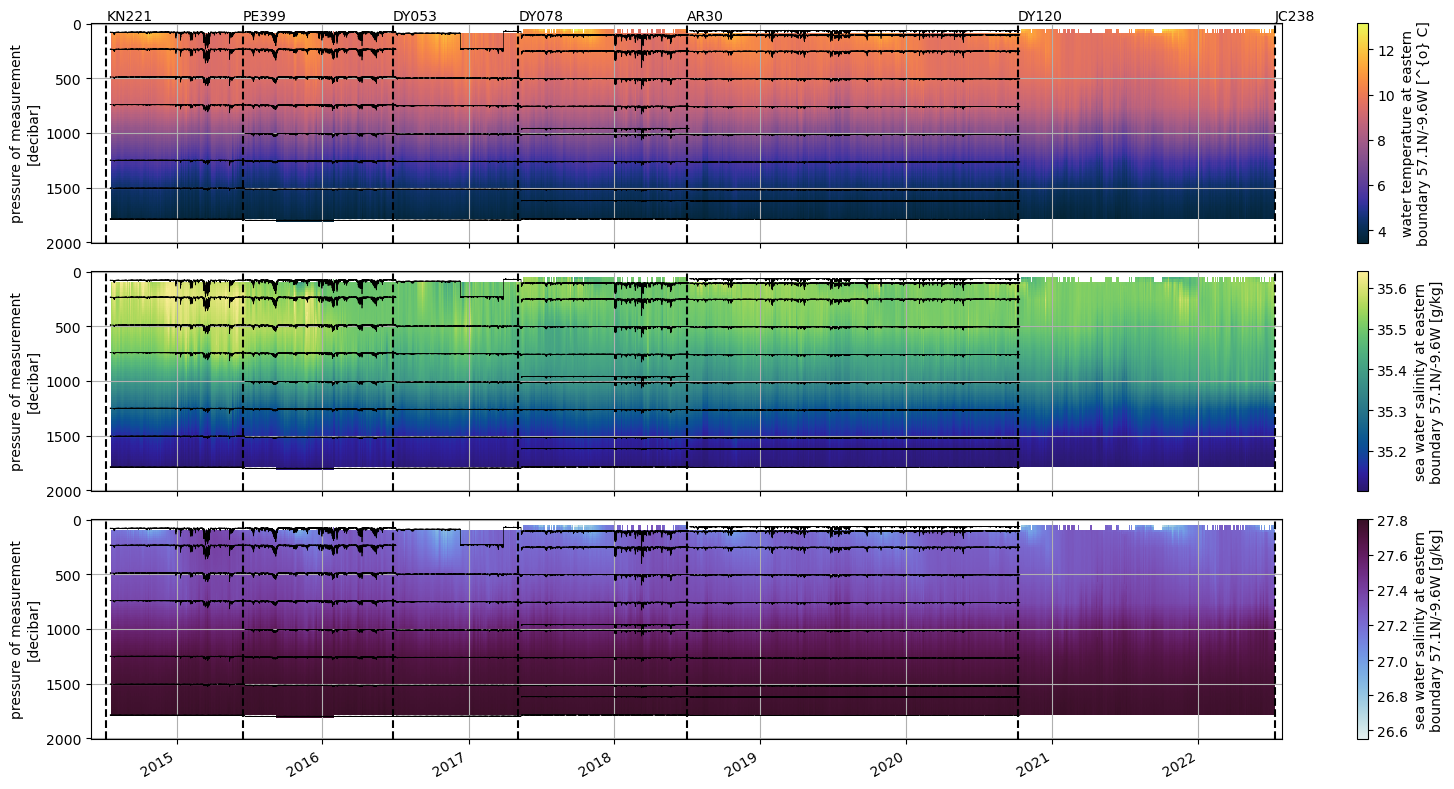

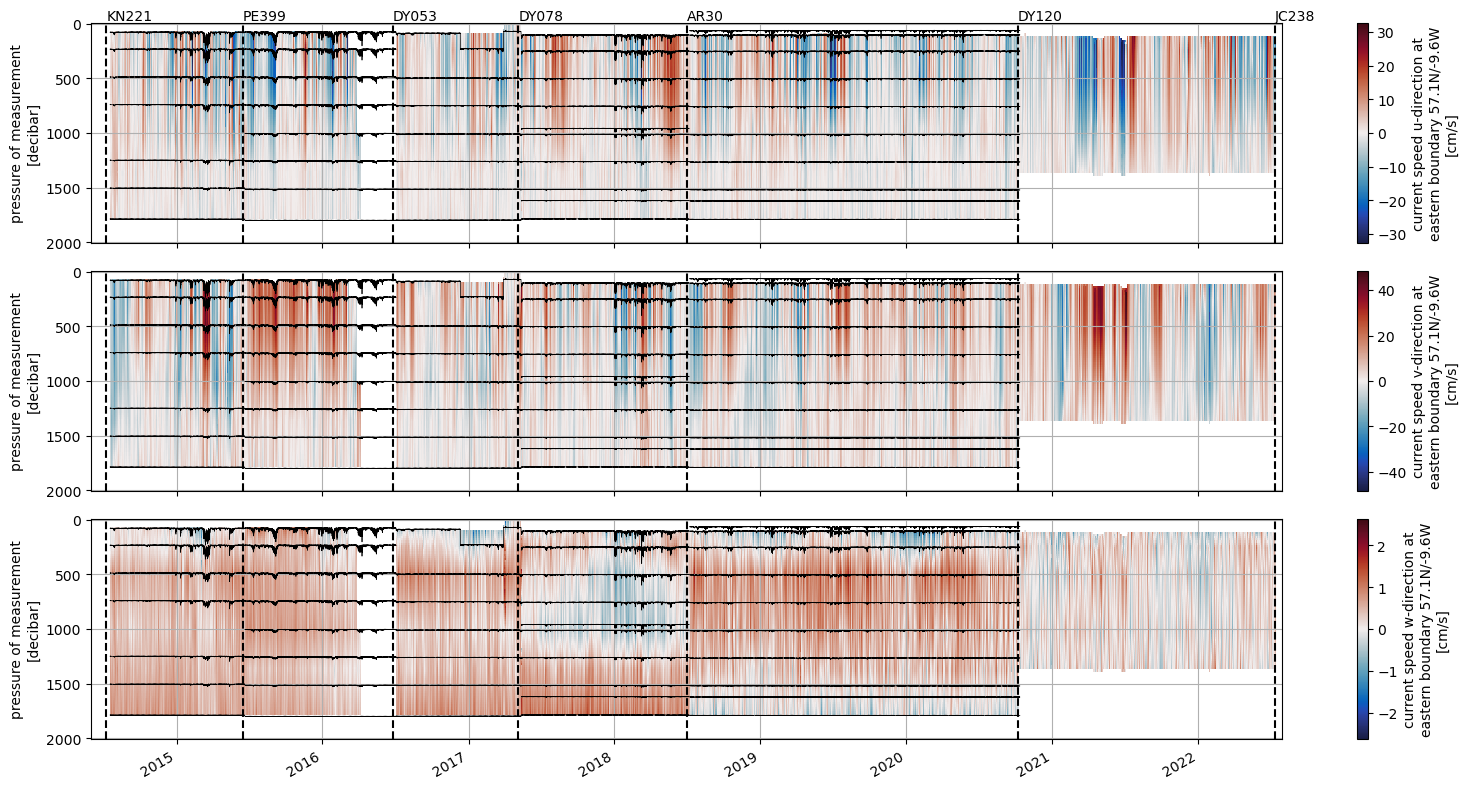

In [20]:
plot_velocity(ds_RT,'EB1','hydrography',ds_EB1.PRES)
plot_velocity(ds_RT,'EB1','velocity',ds_EB1.PRES)

# WB1

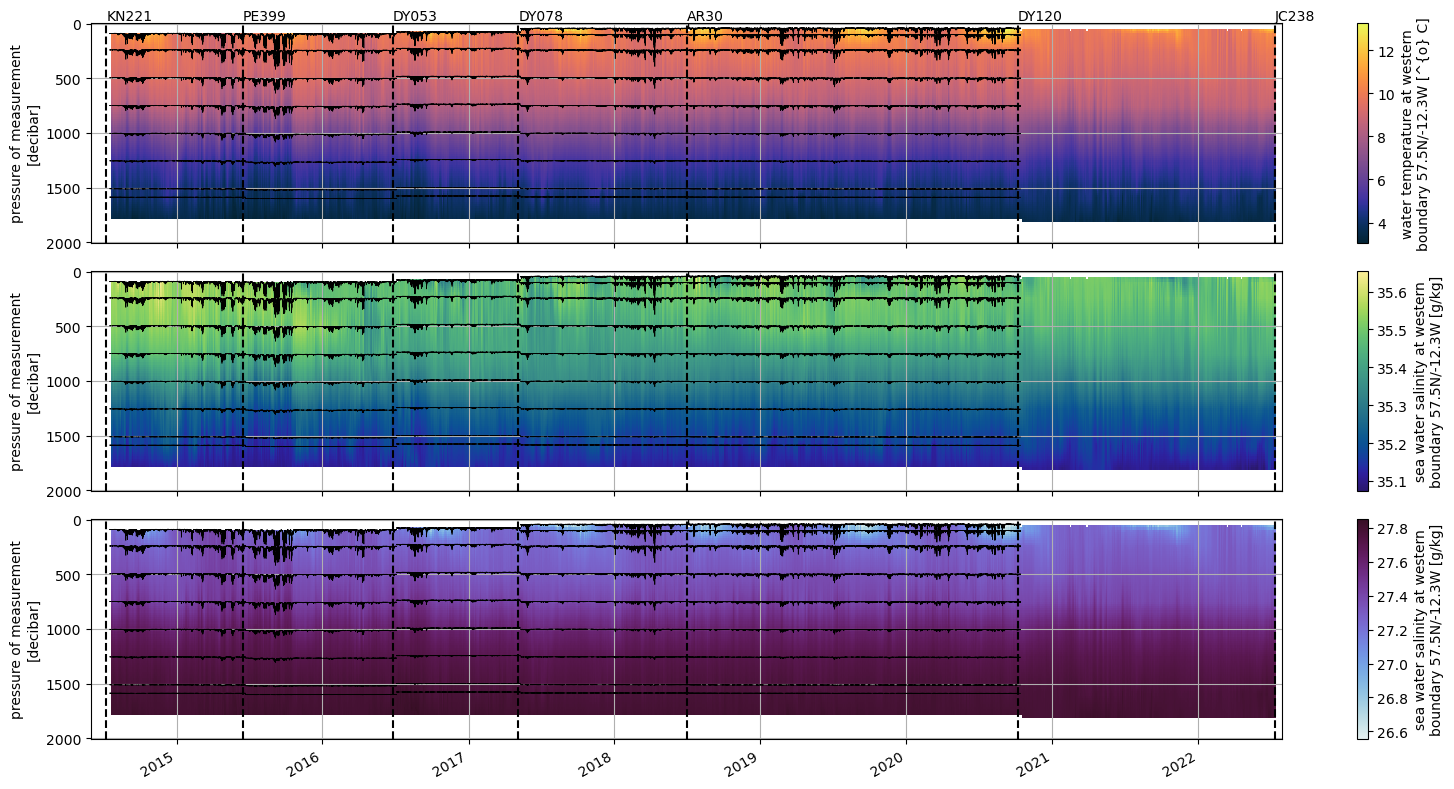

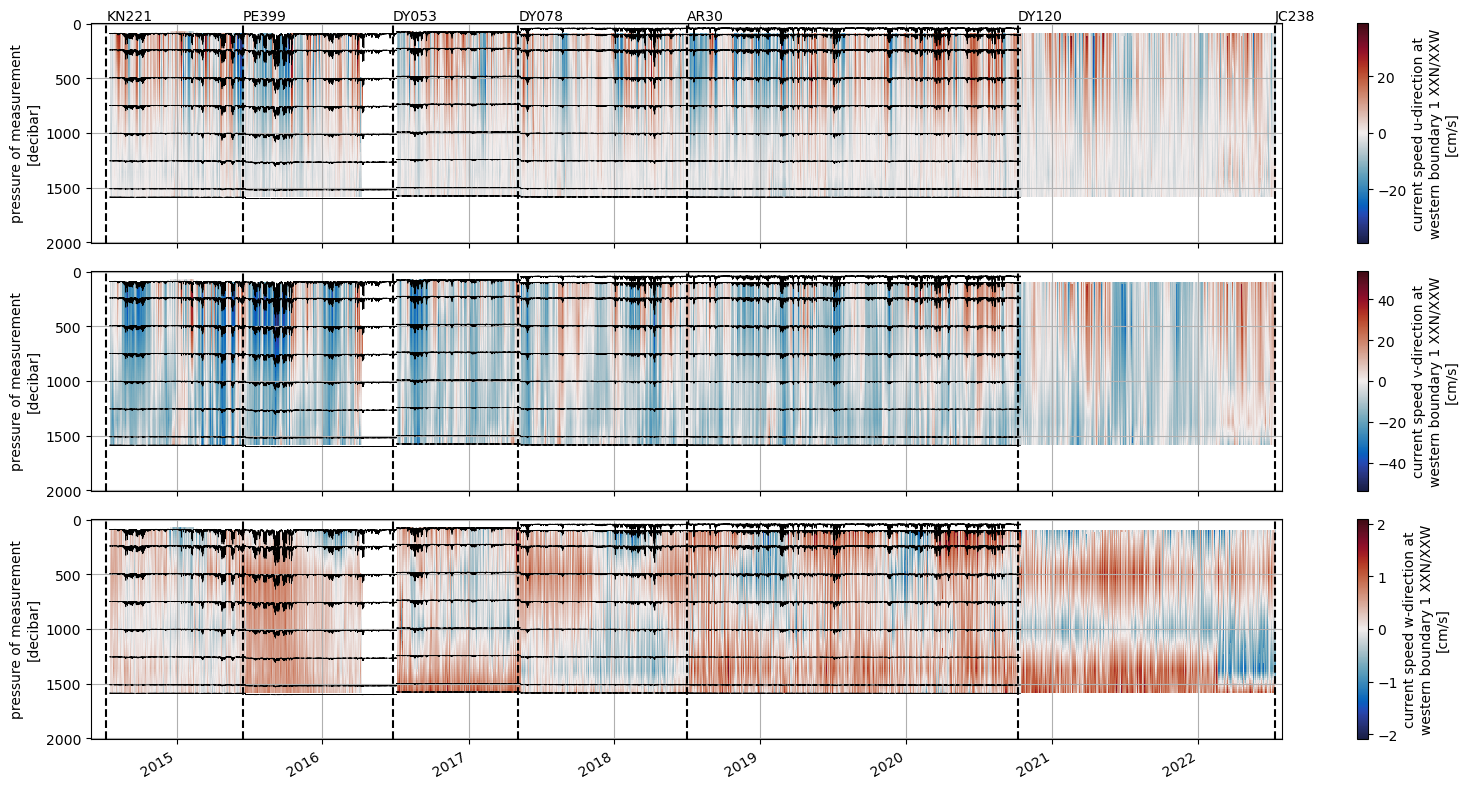

In [21]:
plot_velocity(ds_RT,'WB1','hydrography',ds_WB1.PRES)
plot_velocity(ds_RT,'WB1','velocity',ds_WB1.PRES)

# WB2

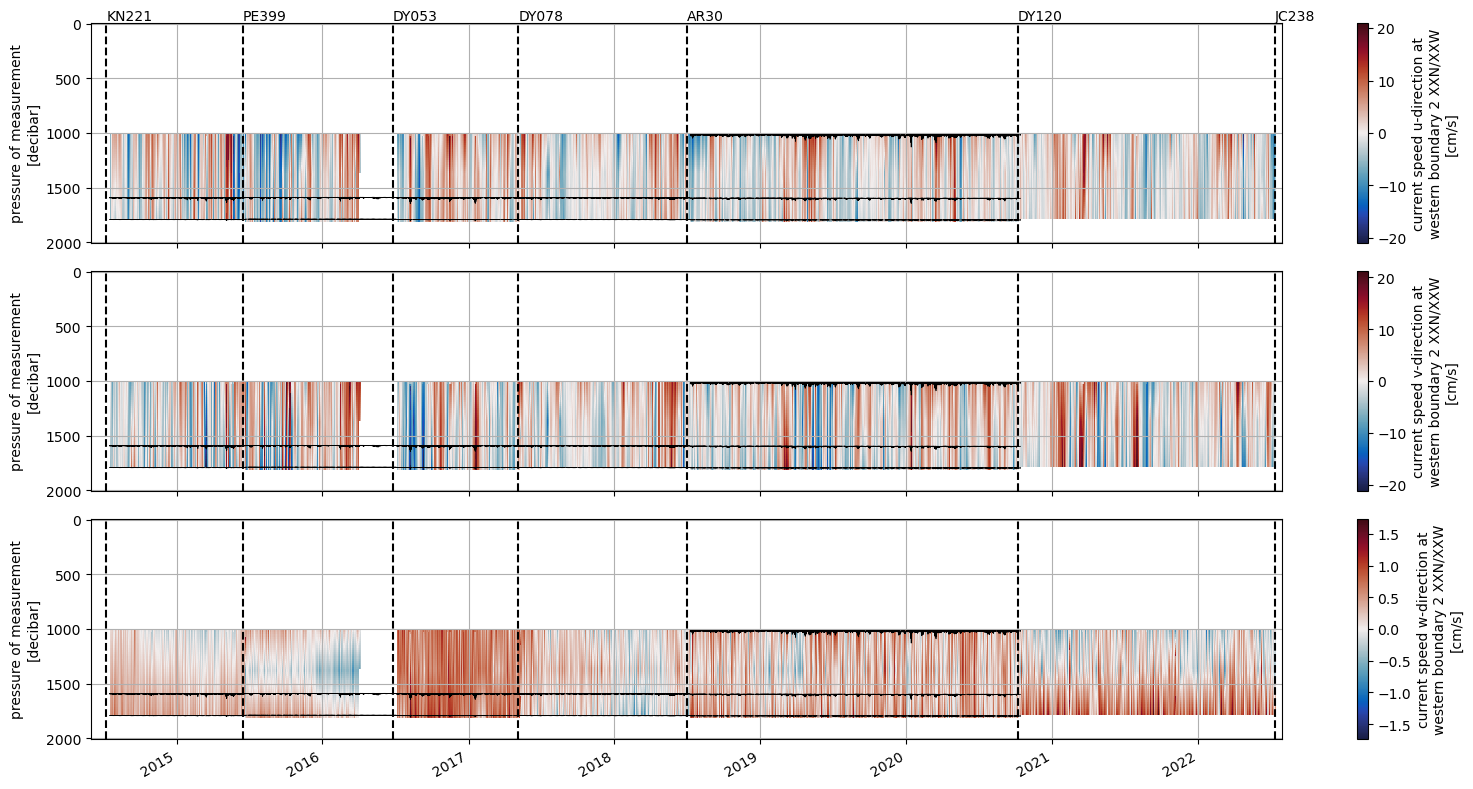

In [22]:
plot_velocity(ds_RT,'WB2','velocity',ds_WB2.PRES)

# Zoom

C:\Users\sa07kb\AppData\Local\Continuum\miniconda3\envs\OSNAP_I\lib\site-packages\xarray\coding\variables.py:148: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


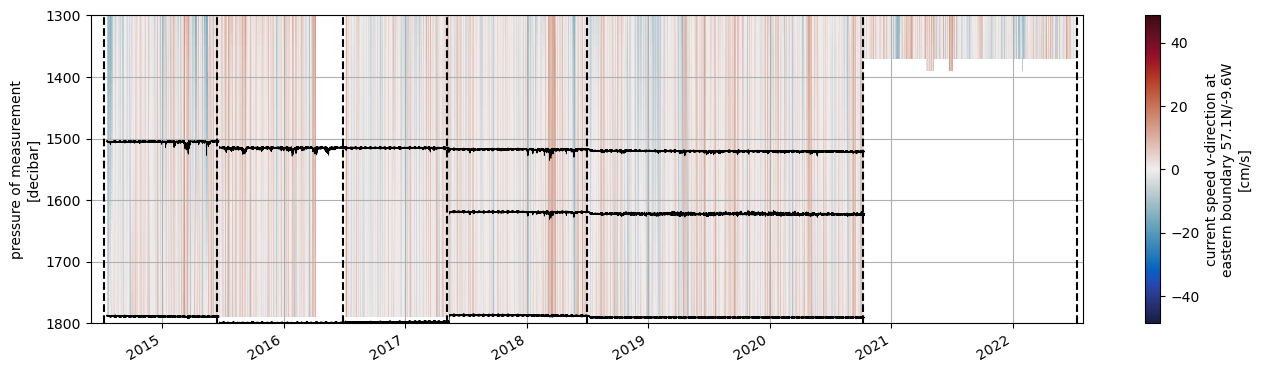

In [25]:
fig,axs = plt.subplots(1,1,figsize=[16,4],sharex=True)
ax = axs
ds_RT.V_EAST.plot(ax=ax,x='TIME',yincrease=False,cmap=cm.cm.balance)

ds_EB1.PRES.plot.line('k',ax=ax,x='TIME',hue='DEPTH',add_legend=False,lw=0.5)
ax.vlines(ds_cruises.TIME,0, 1,transform=ax.get_xaxis_transform(),color='k',linestyle='--')
ax.set_xlabel('')
ax.grid()

for i,text in enumerate(ds_cruises):
    ax.annotate(text.values, xy=(ds_cruises[i].TIME,-5),va='bottom')
    ax.set_ylim([1800,1300])

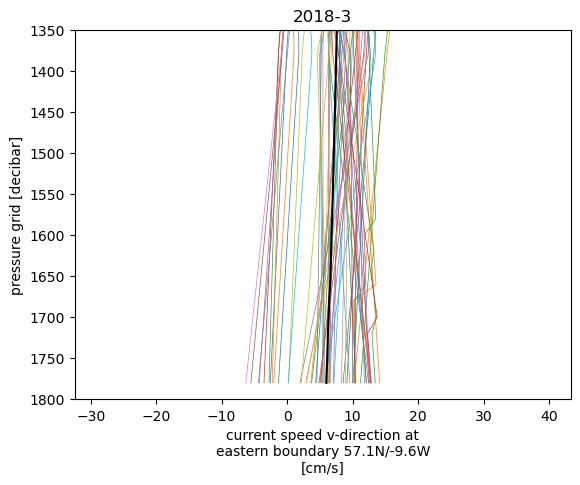

In [91]:
t='2018-3'
ds_RT.V_EAST.sel(TIME=t).plot(y='PRES',hue='TIME',ylim=[1800,1350],add_legend=False,lw=0.5);
ds_RT.V_EAST.sel(TIME=t).mean('TIME',keep_attrs=True).plot.line('k',y='PRES',ylim=[1800,1350],add_legend=False)
plt.title(t);

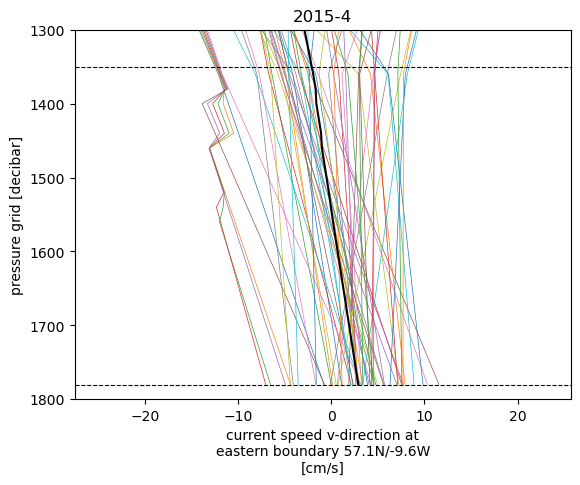

In [104]:
t='2015-4'
ds_RT.V_EAST.sel(TIME=t).plot(y='PRES',hue='TIME',ylim=[1800,1300],add_legend=False,lw=0.5);
ds_RT.V_EAST.sel(TIME=t).mean('TIME',keep_attrs=True).plot.line('k',y='PRES',ylim=[1800,1300],add_legend=False)
plt.axhline(1350,color='k',lw=0.8,ls='--')
plt.axhline(1780,color='k',lw=0.8,ls='--')
plt.title(t);